In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import multiprocessing

In [ ]:
def vector_product(x, y):
    return x[:, :, :, 0]*y[:, :, :, 1] - x[:, :, :, 1]*y[:, :, :, 0]

def intersect(x1, d1, x2, d2):
    """
    Arguments:
    x1, d1: (n, d, 2)
    x2, d2: (m, 2)
    return: tu: (n, m, 2)
        x1[k] + tu[k, l, 0] * d1[k] == x2[l] + tu[k, l, 1] * d2[l]
    """
    x1 = x1[:, :, None, :]
    x2 = x2[None, None, :, :]
    d1 = d1[:, :, None, :]
    d2 = d2[None, None, :, :]
    rs = vector_product(d1, d2)
    t = vector_product(x2 - x1, d2) / rs
    u = vector_product(x2 - x1, d1) / rs
    tu = np.stack([t, u], 3)
    m = np.any((tu < 0) | (tu > 1), axis=3)
    tu[m] = np.nan
    return tu

def make_rectangle(x1, x2):
    """
    Arguments:
    x1: lower left corner
    x2: upper right corner
    """
    dx = np.array([x2[0] - x1[0], 0])
    dy = np.array([0, x2[1] - x1[1]])
    
    return np.vstack([x1, x1, x2, x2]), np.vstack([dx, dy, -dx, -dy])

def alphas_to_coords(S, x0, y0, alphas):
    S = np.array(S)
    alphas = np.cumsum(alphas, 1)
    x = np.zeros((alphas.shape[0], alphas.shape[1]+1, 2))
    x[:, 0, :] = np.array([x0, y0])
    d = np.stack([S * np.cos(alphas), S * np.sin(alphas)], 2)
    x[:, 1:, :] = d
    x = np.cumsum(x, 1)
    return x, d

# TODO: optimize if needed
def rectangle_penalty(s1, x1, s2, x2, rectangle_x, rectangle_d, max_h):
    if s1 == s2:
        return np.abs(np.sum(x2 - x1)) * max_h / 2
    elif s1 % 2 == s2 % 2:
        h = np.abs(rectangle_d[(s1+1) % 4, :].sum())
        s = min(s1, s2)
        a = np.abs(x1[s] - rectangle_x[0, s])
        b = np.abs(x2[s] - rectangle_x[0, s])
        S = (a + b) * h / 2
        S_total = rectangle_d[0, 0] * rectangle_d[1, 1]
        return min(S, S_total - S)
    else:
        x = np.abs(x2 - x1)
        return x[0] * x[1] / 2

def rectangle_total_penalty(population_x, population_d, rectangle_x, rectangle_d):
    n, d = population_d.shape[:2]
    intersections = intersect(population_x[:, :-1, :], population_d, rectangle_x, rectangle_d)
    does_intersect = np.any(~np.isnan(intersections), 3)
    penalty = np.zeros(n)
    for t in range(n):
        intersection_side = None
        intersection_point = None
        max_h = 0.
        for i in range(d):
            if intersection_side is not None:
                s = (intersection_side+1) % 2
                max_h = max(max_h, np.abs(population_x[t, i, s] - intersection_point[s]))
            for j in range(4):
                if does_intersect[t, i, j]:
                    j_point = population_x[t, i] + population_d[t, i] * intersections[t, i, j, 0]
                    if intersection_side is not None:
                        penalty[t] += rectangle_penalty(intersection_side, intersection_point, j, j_point, rectangle_x, rectangle_d, max_h)
                        intersection_side = None
                    else:
                        intersection_side = j
                        intersection_point = j_point
                        max_h = 0.
        if intersection_side is not None:
            penalty[t] += rectangle_d[0, 0] * rectangle_d[1, 1]
    return penalty

def inverse_kinematics_objective(S, target_x, target_y, rectangles):
    rectangle_segments = [make_rectangle(*rect) for rect in rectangles]
    target = np.array([target_x, target_y])
    
    def objective(population):
        population_x, population_d = alphas_to_coords(S, 0, 0, population)
        score = np.sum((population_x[:, -1, :] - target)**2, 1)
        results = [score]
        
        for rectangle_x, rectangle_d in rectangle_segments:
            rectangle_penalties = rectangle_total_penalty(population_x, population_d, rectangle_x, rectangle_d)
            results.append(rectangle_penalties)
        
        results = np.stack(results, 1)
        results[:, 1:] = np.maximum(results[:, 1:], 0.)
        return results
    
    return objective
    
def draw_solutions(alphas, S, target_x, target_y, rectangles, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    x, d = alphas_to_coords(S, 0, 0, alphas)
    for rect in rectangles:
        rect_x, rect_d = make_rectangle(*rect)
        rect_patch = patches.Rectangle(rect_x[0, :], rect_d[0, 0], rect_d[1, 1], edgecolor="k", facecolor=(0, 0, 0, 0), linewidth=3)
        ax.add_patch(rect_patch)
        
    plt.scatter(target_x, target_y, c="red", s=400)
    ax.set_aspect("equal", "box")
    for specimen_x in x:
        ax.plot(specimen_x[:, 0], specimen_x[:, 1], marker='D')

In [ ]:
def FNS(scores):
    domination = (scores[:, None, :] <= scores[None, :, :]).all(2) # domination[i, j] = "i dominuje j"
    domination &= ~(scores[:, None, :] == scores[None, :, :]).all(2)
    Nx = domination.sum(0)
    
    Pf = []
    ranks = np.zeros(scores.shape[0])
    r = 0
    Q = np.argwhere(Nx == 0)
    while Q.size > 0:
        Q = Q[:, 0]
        Nx[Q] = -1
        Pf.append(Q)
        ranks[Q] = r
        r += 1
        for i in Q:
            Nx[domination[i, :]] -= 1
        Q = np.argwhere(Nx == 0)
        
    return Pf, ranks

def crowding_distance(scores):
    indices = np.argsort(scores, 0)
    sorted_scores = np.take_along_axis(scores, indices, 0)
    cd = np.zeros(scores.shape[0])
    for k in range(scores.shape[1]):
        if sorted_scores[-1, k] != sorted_scores[0, k]:
            cd[indices[[0, -1], k]] = np.inf
            cd[indices[1:-1, k]] += (sorted_scores[2:, k] - sorted_scores[:-2, k]) / (sorted_scores[-1, k] - sorted_scores[0, k])
    return cd

def random_population(d, n, x_min, x_max):
    return np.hstack([np.random.uniform(x_min, x_max, (n, d))])

def tournament_selection(ranks, dists, n):
    candidates = np.random.choice(n, (n, 2), replace=True)
    mask = np.where(
        ranks[candidates[:, 0]] == ranks[candidates[:, 1]],
        dists[candidates[:, 0]] > dists[candidates[:, 1]],
        ranks[candidates[:, 0]] < ranks[candidates[:, 1]]
    )
    result = candidates[:, 1]
    result[mask] = candidates[mask, 0]
    return result

def crossover(x, p, eta): # simulated binary crossover
    n, d = x.shape
    l = n // 2
    mask = np.random.random(l) <= p
    m = np.sum(mask)
    mi = np.random.random((m, d))
    beta = np.where(
        mi < 0.5,
        np.power(2*mi, 1. / (eta+1.)),
        np.power(1. / (2.*(1-mi)), 1. / (eta+1.))
    )
    c1 = x[:l, :].copy()
    c2 = x[l:, :].copy()
    c1[mask, :] = 0.5 * (1 + beta) * x[:l, :][mask, :] + 0.5 * (1 - beta) * x[l:, :][mask, :]
    c2[mask, :] = 0.5 * (1 + beta) * x[:l, :][mask, :] + 0.5 * (1 - beta) * x[l:, :][mask, :]
    return np.vstack([c1, c2])

def mutation(x, x_min, x_max, p, eta): # polynomial mutation
    n, d = x.shape
    mask = np.random.random(x.shape[0]) <= p
    m = np.sum(mask)
    mi = np.random.random((m, d))
    beta = np.where(
        mi < 0.5,
        np.power(2*mi, 1. / (eta+1.)) - 1.,
        1. - np.power(2.*(1-mi), 1. / (eta+1.))
    )
    y = x.copy()
    y[mask, :] = np.where(
        mi < 0.5,
        x[mask, :] + beta * (x[mask, :] - x_min),
        x[mask, :] + beta * (x_max - x[mask, :])
    )
    return y

def elitist_selection(fronts, dists, to_take):
    taken = []
    for front in fronts:
        if len(front) <= to_take:
            taken += list(front)
            if len(front) == to_take:
                break
            to_take -= len(front)
        else:
            indices = np.argsort(-dists[front])[:to_take]
            taken += list(front[indices])
            break
    return taken

def constraint_violation(constraints):
    n, d = constraints.shape
    sort_indices = np.argsort(constraints, 0)
    violations = np.zeros(n)
    for i in range(d):
        values, counts = np.unique(constraints[:, i], return_counts=True) # unikalne wartości są zwracane posortowane
        counts = np.cumsum(counts)
        counts = list(counts)
        if values[0] != 0:
            counts = [0] + counts
        for rank, (j, k) in enumerate(zip([0] + counts, counts + [len(counts)])):
            violations[sort_indices[j:k, i]] += rank
    return violations
        

def IDEA(objective, n_constraints, x_min, x_max, d, n, n_inf, eta_c, eta_m, p_c, p_m, num_iterations, log_interval=10):
    n_f = n - n_inf
    population = random_population(d, n, x_min, x_max)
    populations = [population.copy()]
    obj_results = objective(population)
    constraint_values = obj_results[:, -n_constraints:]
    violation_measure = constraint_violation(constraint_values)
    scores = np.concatenate([obj_results[:, :-n_constraints], violation_measure[:, None]], 1)
    scores_hist = [scores.copy()]

    fronts, ranks = FNS(scores)
    dists = crowding_distance(scores)
    
    for iter_ in range(num_iterations):
        parent_indices = tournament_selection(ranks, dists, n)
        offspring = crossover(population[parent_indices, :], p_c, eta_c)
        offspring = np.clip(offspring, x_min, x_max)
        offspring = mutation(offspring, x_min, x_max, p_m, eta_m)
        
        offspring_obj_results = objective(offspring)
        offspring_constraint_values = offspring_obj_results[:, -n_constraints:]
        offspring_violation_measure = constraint_violation(offspring_constraint_values)
        offspring_scores = np.concatenate([offspring_obj_results[:, :-n_constraints], offspring_violation_measure[:, None]], 1)
        
        population = np.vstack([population, offspring])
        scores = np.vstack([scores, offspring_scores])
        
        dists = crowding_distance(scores)
        mask_f = scores[:, -1] == 0
        mask_inf = ~mask_f
        s_f = np.sum(mask_f)
        s_inf = np.sum(mask_inf)
        if s_f < n_f:
            to_take_f = s_f
            to_take_inf = n - s_f
        elif s_inf < n_inf:
            to_take_inf = s_inf
            to_take_f = n - s_inf
        else:
            to_take_f = n_f
            to_take_inf = n_inf
            
        population_f = population[mask_f, :]
        scores_f = scores[mask_f, :]
        dists_f = dists[mask_f]
        fronts, ranks = FNS(population_f)
        taken_f = elitist_selection(fronts, dists_f, to_take_f)
        
        population_inf = population[mask_inf]
        scores_inf = scores[mask_inf, :]
        dists_inf = dists[mask_inf]
        fronts, ranks = FNS(population_inf)
        taken_inf = elitist_selection(fronts, dists_inf, to_take_inf)
        
        population = np.vstack([population_f[taken_f, :], population_inf[taken_inf, :]])
        scores = np.vstack([scores_f[taken_f, :], scores_inf[taken_inf, :]])
        dists = np.hstack([dists_f[taken_f], dists_inf[taken_inf]])
        fronts, ranks = FNS(population)
        
        populations.append(population.copy())
        scores_hist.append(scores.copy())
        
        if iter_ % log_interval == 0:
            print(f"Iteration {iter_}, #feasible: {to_take_f}, #infeasible: {to_take_inf}, scores: {scores.min(0)} {scores.mean(0)} {scores.max(0)}")
    print(f"Iteration {iter_}, #feasible: {to_take_f}, #infeasible: {to_take_inf}, scores: {scores.min(0)} {scores.mean(0)} {scores.max(0)}")
    return np.stack(populations, 0), np.stack(scores_hist, 0)

In [28]:
rectangles = [((0.5, 4.), (2., 5.5))]
target_x = 1.2
target_y = 8.
S = [1.] * 20 + [0.3] * 5
d = len(S)
x_min = -np.pi
x_max = np.pi

objective = inverse_kinematics_objective(S, target_x, target_y, rectangles)
n_constraints = len(rectangles)

n = 600
n_inf = int(0.15*n)
eta_c = 5.
eta_m = 40.
p_c = 0.9
p_m = 0.2
num_iterations = 1800

populations, scores = IDEA(objective, n_constraints, x_min, x_max, d, n, n_inf, eta_c, eta_m, p_c, p_m, num_iterations, log_interval=80)

Iteration 0, #feasible: 510, #infeasible: 90, scores: [0.03680196 0.        ] [91.4220572  4.63     ] [340.39153322  64.        ]


/home/i291318/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/i291318/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


Iteration 80, #feasible: 510, #infeasible: 90, scores: [0.00208032 0.        ] [394.34185232   8.41666667] [783.98574614 119.        ]
Iteration 160, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [406.73522561   8.63666667] [832.15518662 127.        ]
Iteration 240, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [419.31675823   9.70833333] [839.40904638 127.        ]
Iteration 320, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [416.59539171   8.835     ] [845.73123634 127.        ]
Iteration 400, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [421.26183188   8.68      ] [852.58891805 127.        ]
Iteration 480, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [427.50712412   9.24      ] [859.16612899 127.        ]
Iteration 560, #feasible: 510, #infeasible: 90, scores: [0.00022661 0.        ] [436.95073169   8.55166667] [866.16162492 127.        ]
Iteration 640, #feasible: 510, #infeasible: 90, s

In [29]:
scores[-1, scores[-1, :, 1] == 0., 0].min()

0.0001520721040992018

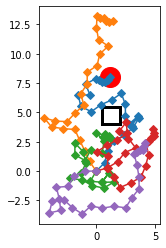

In [30]:
mask = scores[-1, :, 1] == 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 0])[:5]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)

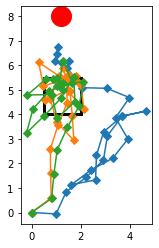

In [31]:
mask = scores[-1, :, 1] > 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 0])[:3]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)

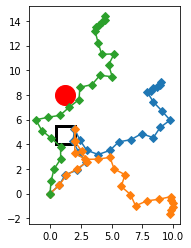

In [32]:
mask = scores[-1, :, 1] > 0.
feasible_population = populations[-1][mask, :]
best = np.argsort(scores[-1, mask, 1])[:3]
draw_solutions(feasible_population[best, :], S, target_x, target_y, rectangles)